# Creating External Forcing Conditions

## Import Modules

In [10]:
import gc
import os
import time
from pathlib import Path

import cmocean.cm as cm
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm.notebook import tqdm, trange

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Functions (NumPy & JAX) & CUDA Check

In [11]:
def read_ecco_exf_file(
    data_dir_exf: str, file_prefix: str, year: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Reads ECCO V5 Alpha external forcing files."""
    lon_exf_np = np.arange(0, 360, 0.7031250, dtype=np.float32)
    lon_exf_np[lon_exf_np > 180] -= 360
    first_index = np.where(lon_exf_np < 0)[0][0]
    lon_exf_np = np.concatenate([lon_exf_np[first_index:], lon_exf_np[:first_index]])

    del_lat_np = np.concatenate(
        [
            np.array([0]),
            np.array([0.6958694]),
            np.array([0.6999817]),
            np.array([0.7009048]),
            np.array([0.7012634]),
            np.array([0.7014313]),
            0.7017418 * np.ones((245,)),
            np.array([0.7014313]),
            np.array([0.7012634]),
            np.array([0.7009048]),
            np.array([0.6999817]),
            np.array([0.6958694]),
        ]
    ).astype(np.float32)
    lat_exf_np = np.cumsum(del_lat_np) + -89.4628220
    lat_exf_np = lat_exf_np.astype(np.float32)

    file_path = os.path.join(data_dir_exf, f"{file_prefix}_{year}")
    try:
        grid_data_np = np.fromfile(file_path, ">f4")
    except FileNotFoundError:
        print(f"ERROR: EXF file not found: {file_path}")
        raise

    expected_elements_per_timestep = len(lon_exf_np) * len(lat_exf_np)
    if grid_data_np.size == 0:
        raise ValueError(f"File {file_path} is empty.")
    if grid_data_np.size % expected_elements_per_timestep != 0:
        raise ValueError(
            f"File size {grid_data_np.size} for {file_path} (elements: {grid_data_np.size}) is not a multiple of ECCO grid slice size ({expected_elements_per_timestep} elements: {len(lat_exf_np)} lat x {len(lon_exf_np)} lon)."
        )

    n_timesteps = grid_data_np.size // expected_elements_per_timestep

    grid_data_np = np.reshape(
        grid_data_np, (n_timesteps, len(lat_exf_np), len(lon_exf_np))
    )
    grid_data_np = np.concatenate(
        [grid_data_np[:, :, first_index:], grid_data_np[:, :, :first_index]], axis=2
    )
    return lon_exf_np, lat_exf_np, grid_data_np


@jax.jit
def create_surface_mask_jax(bathy_jax: jax.Array) -> jax.Array:
    return jnp.where(bathy_jax < 0, 1, 0).astype(jnp.int32)


@jax.jit
def downscale_2d_points_jax_nearest(
    source_xy_jax: jax.Array,
    source_values_flat_jax: jax.Array,
    source_mask_flat_jax: jax.Array,
    target_xc_jax: jax.Array,
    target_yc_jax: jax.Array,
    target_mask_2d_jax: jax.Array,
) -> jax.Array:
    target_n_rows, target_n_cols = target_xc_jax.shape
    target_lon_flat = target_xc_jax.ravel()
    target_lat_flat = target_yc_jax.ravel()
    target_pts = jnp.stack([target_lon_flat, target_lat_flat], axis=-1)[:, None, :]
    source_pts = source_xy_jax[None, :, :]
    dist_sq = jnp.sum((target_pts - source_pts) ** 2, axis=2)
    nearest_indices = jnp.argmin(dist_sq, axis=1)
    gathered_values = source_values_flat_jax[nearest_indices]
    gathered_mask = source_mask_flat_jax[nearest_indices]
    interpolated_flat = jnp.where(gathered_mask > 0, gathered_values, 0.0)
    interpolated_grid = interpolated_flat.reshape((target_n_rows, target_n_cols))
    final_interpolated_grid = jnp.where(target_mask_2d_jax > 0, interpolated_grid, 0.0)
    return final_interpolated_grid


print(f"JAX backend: {jax.default_backend()}")
try:
    gpu_device = jax.devices("gpu")[0]
    _ = jnp.zeros(1, dtype=jnp.float32).block_until_ready()
    print(f"JAX devices: {jax.devices()}")
    print("GPU access confirmed.")
except (RuntimeError, IndexError) as e:
    print(f"Warning: Could not access GPU. Using CPU. Error: {e}")
    gpu_device = jax.devices("cpu")[0]

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
GPU access confirmed.


## Configurations

In [12]:
MYDRIVE_DIR = Path("/content/drive/MyDrive")
PROJ_ROOT = MYDRIVE_DIR / "cs185c"
input_dir_model = PROJ_ROOT / "input"
data_dir_ecco_exf = PROJ_ROOT / "data"

DEL_X_MODEL = 1
DEL_Y_MODEL = 1
XG_ORIGIN_MODEL = -180
YG_ORIGIN_MODEL = -90
N_ROWS_MODEL = 180
N_COLS_MODEL = 360

## Step One: Read ECCO External Forcing Conditions (EFC)

In [13]:
print("--- Step One: Read ECCO EFC Data (NumPy) ---")
start_step1_time = time.time()
file_prefix_dict = {
    "ATEMP": "EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl",
    "AQH": "EIG_spfh2m_plus_ECCO_v4r1_ctrl",
    "SWDOWN": "EIG_dsw_plus_ECCO_v4r1_ctrl",
    "LWDOWN": "EIG_dlw_plus_ECCO_v4r1_ctrl",
    "UWIND": "EIG_u10m",
    "VWIND": "EIG_v10m",
    "PRECIP": "EIG_rain_plus_ECCO_v4r1_ctrl",
}
variable_names_exf = list(file_prefix_dict.keys())
exf_grids_np_list = []
YEAR_EXF = 2009
exf_lon_np, exf_lat_np = None, None

for field_name in tqdm(variable_names_exf):
    print(f"  Reading {field_name} for {YEAR_EXF}...")
    try:
        current_lon_np, current_lat_np, current_grid_np = read_ecco_exf_file(
            data_dir_ecco_exf, file_prefix_dict[field_name], YEAR_EXF
        )
        if exf_lon_np is None:
            exf_lon_np, exf_lat_np = current_lon_np, current_lat_np
        exf_grids_np_list.append(current_grid_np)
        print(f"    {field_name} loaded. Shape: {current_grid_np.shape}")
    except Exception as e:
        print(f"    ERROR loading {field_name}: {e}. Skipping.")
        exf_grids_np_list.append(None)
if exf_lon_np is None:
    print("ERROR: Failed to load ECCO EXF coordinates. Exiting.")
    exit()
Exf_Lon_np, Exf_Lat_np = np.meshgrid(exf_lon_np, exf_lat_np)
ecco_points_np = np.column_stack([Exf_Lon_np.ravel(), Exf_Lat_np.ravel()]).astype(
    np.float32
)
ecco_mask_np_flat = np.ones(ecco_points_np.shape[0], dtype=np.int32)
step1_time = time.time() - start_step1_time
print(f"Step One completed in {step1_time:.2f}s")

--- Step One: Read ECCO EFC Data (NumPy) ---


  0%|          | 0/7 [00:00<?, ?it/s]

  Reading ATEMP for 2009...
    ATEMP loaded. Shape: (1460, 256, 512)
  Reading AQH for 2009...
    AQH loaded. Shape: (1460, 256, 512)
  Reading SWDOWN for 2009...
    SWDOWN loaded. Shape: (1460, 256, 512)
  Reading LWDOWN for 2009...
    LWDOWN loaded. Shape: (1460, 256, 512)
  Reading UWIND for 2009...
    UWIND loaded. Shape: (1460, 256, 512)
  Reading VWIND for 2009...
    VWIND loaded. Shape: (1460, 256, 512)
  Reading PRECIP for 2009...
    PRECIP loaded. Shape: (1460, 256, 512)
Step One completed in 7.58s


## Step Two: Read in the Model Grid and Create Surface Mask (JAX) ===

In [14]:
print("--- Step Two: Model Grid & Surface Mask (JAX) ---")
start_step2_time = time.time()
xc_model_jax = jnp.arange(
    XG_ORIGIN_MODEL + DEL_X_MODEL / 2,
    XG_ORIGIN_MODEL + N_COLS_MODEL * DEL_X_MODEL,
    DEL_X_MODEL,
    dtype=jnp.float32,
)
yc_model_jax = jnp.arange(
    YG_ORIGIN_MODEL + DEL_Y_MODEL / 2,
    YG_ORIGIN_MODEL + N_ROWS_MODEL * DEL_Y_MODEL + DEL_Y_MODEL / 2,
    DEL_Y_MODEL,
    dtype=jnp.float32,
)
XC_model_jax, YC_model_jax = jnp.meshgrid(xc_model_jax, yc_model_jax, indexing="xy")
XC_model_np, YC_model_np = np.array(XC_model_jax), np.array(YC_model_jax)

bathy_model_file = input_dir_model / "global_bathymetry.bin"
try:
    bathy_model_np = np.fromfile(bathy_model_file, ">f4").reshape(
        (N_ROWS_MODEL, N_COLS_MODEL)
    )
except FileNotFoundError:
    print(f"ERROR: Model bathymetry file not found: {bathy_model_file}")
    exit()
bathy_model_jax = jax.device_put(
    jnp.asarray(bathy_model_np, dtype=jnp.float32), gpu_device
)
del bathy_model_np
gc.collect()
surface_mask_model_jax = create_surface_mask_jax(bathy_model_jax)
surface_mask_model_jax.block_until_ready()
print("Model grid and surface mask created (JAX).")
step2_time = time.time() - start_step2_time
print(f"Step 2 completed in {step2_time:.2f}s")

--- Step Two: Model Grid & Surface Mask (JAX) ---
Model grid and surface mask created (JAX).
Step 2 completed in 0.15s


## Step Three: Interpolate ECF Fields (JAX)

In [15]:
print("--- Step Three: Interpolate EXF Fields (JAX) ---")
start_step3_time = time.time()

print("Transferring ECCO ECF source points/mask to JAX device...")
ecco_points_jax = jax.device_put(jnp.asarray(ecco_points_np), gpu_device)
ecco_mask_jax_flat = jax.device_put(jnp.asarray(ecco_mask_np_flat), gpu_device)
del ecco_points_np
del ecco_mask_np_flat
gc.collect()
print("ECCO ECF source points/mask transferred.")

interpolation_times_ecf = {}
for i, variable_name in tqdm(enumerate(variable_names_exf)):
    current_exf_grid_np = exf_grids_np_list[i]
    if current_exf_grid_np is None:
        print(f"Skipping interpolation for {variable_name}.")
        continue

    print(f"  Interpolating {variable_name}...")
    interp_var_start_time = time.time()
    n_timesteps_var = current_exf_grid_np.shape[0]
    interpolated_variable_all_timesteps_np = np.zeros(
        (n_timesteps_var, N_ROWS_MODEL, N_COLS_MODEL), dtype=np.float32
    )

    for timestep in trange(n_timesteps_var):
        if timestep % 100 == 0 and timestep > 0:
            print(f"    {variable_name}: Timestep {timestep}/{n_timesteps_var}")
        exf_timestep_data_np_flat = current_exf_grid_np[timestep, :, :].ravel()
        exf_timestep_data_jax = jax.device_put(
            jnp.asarray(exf_timestep_data_np_flat), gpu_device
        )
        interpolated_timestep_jax = downscale_2d_points_jax_nearest(
            ecco_points_jax,
            exf_timestep_data_jax,
            ecco_mask_jax_flat,
            XC_model_jax,
            YC_model_jax,
            surface_mask_model_jax,
        )
        interpolated_timestep_jax.block_until_ready()
        interpolated_variable_all_timesteps_np[timestep, :, :] = np.array(
            interpolated_timestep_jax
        )
        del exf_timestep_data_jax, interpolated_timestep_jax
        if timestep > 0 and timestep % 50 == 0:
            gc.collect()

    interpolation_times_ecf[variable_name] = time.time() - interp_var_start_time
    print(
        f"    {variable_name} interpolated ({n_timesteps_var} timesteps) in {interpolation_times_ecf[variable_name]:.2f}s"
    )
    if variable_name == "ATEMP":
        interpolated_variable_all_timesteps_np += 273.15
        print(f"    {variable_name} to K.")
    if variable_name in ["SWDOWN", "LWDOWN"]:
        interpolated_variable_all_timesteps_np *= -1.0
        print(f"    {variable_name} sign reverse.")
    output_file = os.path.join(input_dir_model, f"{variable_name}_{YEAR_EXF}")
    print(
        f"    Saving {output_file} (Shape: {interpolated_variable_all_timesteps_np.shape})"
    )
    interpolated_variable_all_timesteps_np.ravel("C").astype(">f4").tofile(output_file)
    print(f"    {variable_name} saved.")
    del current_exf_grid_np
    del interpolated_variable_all_timesteps_np
    exf_grids_np_list[i] = None
    gc.collect()

del ecco_points_jax
del ecco_mask_jax_flat
gc.collect()

step3_time = time.time() - start_step3_time
print(f"Step Three (Interpolation) completed in {step3_time:.2f}s")
print("Interpolation times per variable:", interpolation_times_ecf)

--- Step Three: Interpolate EXF Fields (JAX) ---
Transferring ECCO ECF source points/mask to JAX device...
ECCO ECF source points/mask transferred.


0it [00:00, ?it/s]

  Interpolating ATEMP...


  0%|          | 0/1460 [00:00<?, ?it/s]

    ATEMP: Timestep 100/1460
    ATEMP: Timestep 200/1460
    ATEMP: Timestep 300/1460
    ATEMP: Timestep 400/1460
    ATEMP: Timestep 500/1460
    ATEMP: Timestep 600/1460
    ATEMP: Timestep 700/1460
    ATEMP: Timestep 800/1460
    ATEMP: Timestep 900/1460
    ATEMP: Timestep 1000/1460
    ATEMP: Timestep 1100/1460
    ATEMP: Timestep 1200/1460
    ATEMP: Timestep 1300/1460
    ATEMP: Timestep 1400/1460
    ATEMP interpolated (1460 timesteps) in 23.62s
    ATEMP to K.
    Saving /content/drive/MyDrive/cs185c/input/ATEMP_2009 (Shape: (1460, 180, 360))
    ATEMP saved.
  Interpolating AQH...


  0%|          | 0/1460 [00:00<?, ?it/s]

    AQH: Timestep 100/1460
    AQH: Timestep 200/1460
    AQH: Timestep 300/1460
    AQH: Timestep 400/1460
    AQH: Timestep 500/1460
    AQH: Timestep 600/1460
    AQH: Timestep 700/1460
    AQH: Timestep 800/1460
    AQH: Timestep 900/1460
    AQH: Timestep 1000/1460
    AQH: Timestep 1100/1460
    AQH: Timestep 1200/1460
    AQH: Timestep 1300/1460
    AQH: Timestep 1400/1460
    AQH interpolated (1460 timesteps) in 23.48s
    Saving /content/drive/MyDrive/cs185c/input/AQH_2009 (Shape: (1460, 180, 360))
    AQH saved.
  Interpolating SWDOWN...


  0%|          | 0/1460 [00:00<?, ?it/s]

    SWDOWN: Timestep 100/1460
    SWDOWN: Timestep 200/1460
    SWDOWN: Timestep 300/1460
    SWDOWN: Timestep 400/1460
    SWDOWN: Timestep 500/1460
    SWDOWN: Timestep 600/1460
    SWDOWN: Timestep 700/1460
    SWDOWN: Timestep 800/1460
    SWDOWN: Timestep 900/1460
    SWDOWN: Timestep 1000/1460
    SWDOWN: Timestep 1100/1460
    SWDOWN: Timestep 1200/1460
    SWDOWN: Timestep 1300/1460
    SWDOWN: Timestep 1400/1460
    SWDOWN interpolated (1460 timesteps) in 23.42s
    SWDOWN sign reverse.
    Saving /content/drive/MyDrive/cs185c/input/SWDOWN_2009 (Shape: (1460, 180, 360))
    SWDOWN saved.
  Interpolating LWDOWN...


  0%|          | 0/1460 [00:00<?, ?it/s]

    LWDOWN: Timestep 100/1460
    LWDOWN: Timestep 200/1460
    LWDOWN: Timestep 300/1460
    LWDOWN: Timestep 400/1460
    LWDOWN: Timestep 500/1460
    LWDOWN: Timestep 600/1460
    LWDOWN: Timestep 700/1460
    LWDOWN: Timestep 800/1460
    LWDOWN: Timestep 900/1460
    LWDOWN: Timestep 1000/1460
    LWDOWN: Timestep 1100/1460
    LWDOWN: Timestep 1200/1460
    LWDOWN: Timestep 1300/1460
    LWDOWN: Timestep 1400/1460
    LWDOWN interpolated (1460 timesteps) in 23.44s
    LWDOWN sign reverse.
    Saving /content/drive/MyDrive/cs185c/input/LWDOWN_2009 (Shape: (1460, 180, 360))
    LWDOWN saved.
  Interpolating UWIND...


  0%|          | 0/1460 [00:00<?, ?it/s]

    UWIND: Timestep 100/1460
    UWIND: Timestep 200/1460
    UWIND: Timestep 300/1460
    UWIND: Timestep 400/1460
    UWIND: Timestep 500/1460
    UWIND: Timestep 600/1460
    UWIND: Timestep 700/1460
    UWIND: Timestep 800/1460
    UWIND: Timestep 900/1460
    UWIND: Timestep 1000/1460
    UWIND: Timestep 1100/1460
    UWIND: Timestep 1200/1460
    UWIND: Timestep 1300/1460
    UWIND: Timestep 1400/1460
    UWIND interpolated (1460 timesteps) in 23.40s
    Saving /content/drive/MyDrive/cs185c/input/UWIND_2009 (Shape: (1460, 180, 360))
    UWIND saved.
  Interpolating VWIND...


  0%|          | 0/1460 [00:00<?, ?it/s]

    VWIND: Timestep 100/1460
    VWIND: Timestep 200/1460
    VWIND: Timestep 300/1460
    VWIND: Timestep 400/1460
    VWIND: Timestep 500/1460
    VWIND: Timestep 600/1460
    VWIND: Timestep 700/1460
    VWIND: Timestep 800/1460
    VWIND: Timestep 900/1460
    VWIND: Timestep 1000/1460
    VWIND: Timestep 1100/1460
    VWIND: Timestep 1200/1460
    VWIND: Timestep 1300/1460
    VWIND: Timestep 1400/1460
    VWIND interpolated (1460 timesteps) in 23.39s
    Saving /content/drive/MyDrive/cs185c/input/VWIND_2009 (Shape: (1460, 180, 360))
    VWIND saved.
  Interpolating PRECIP...


  0%|          | 0/1460 [00:00<?, ?it/s]

    PRECIP: Timestep 100/1460
    PRECIP: Timestep 200/1460
    PRECIP: Timestep 300/1460
    PRECIP: Timestep 400/1460
    PRECIP: Timestep 500/1460
    PRECIP: Timestep 600/1460
    PRECIP: Timestep 700/1460
    PRECIP: Timestep 800/1460
    PRECIP: Timestep 900/1460
    PRECIP: Timestep 1000/1460
    PRECIP: Timestep 1100/1460
    PRECIP: Timestep 1200/1460
    PRECIP: Timestep 1300/1460
    PRECIP: Timestep 1400/1460
    PRECIP interpolated (1460 timesteps) in 23.37s
    Saving /content/drive/MyDrive/cs185c/input/PRECIP_2009 (Shape: (1460, 180, 360))
    PRECIP saved.
Step Three (Interpolation) completed in 169.54s
Interpolation times per variable: {'ATEMP': 23.624321222305298, 'AQH': 23.48248553276062, 'SWDOWN': 23.41606879234314, 'LWDOWN': 23.436737775802612, 'UWIND': 23.404727935791016, 'VWIND': 23.392968893051147, 'PRECIP': 23.371559858322144}


## Step Four: Plotting the External Forcing Fields (NumPy)

--- Step Four: Plotting EXF Fields ---


0it [00:00, ?it/s]

DEBUG: Plotting ATEMP: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting AQH: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting SWDOWN: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting LWDOWN: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting UWIND: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting VWIND: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
DEBUG: Plotting PRECIP: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360


  0%|          | 0/2 [00:00<?, ?it/s]

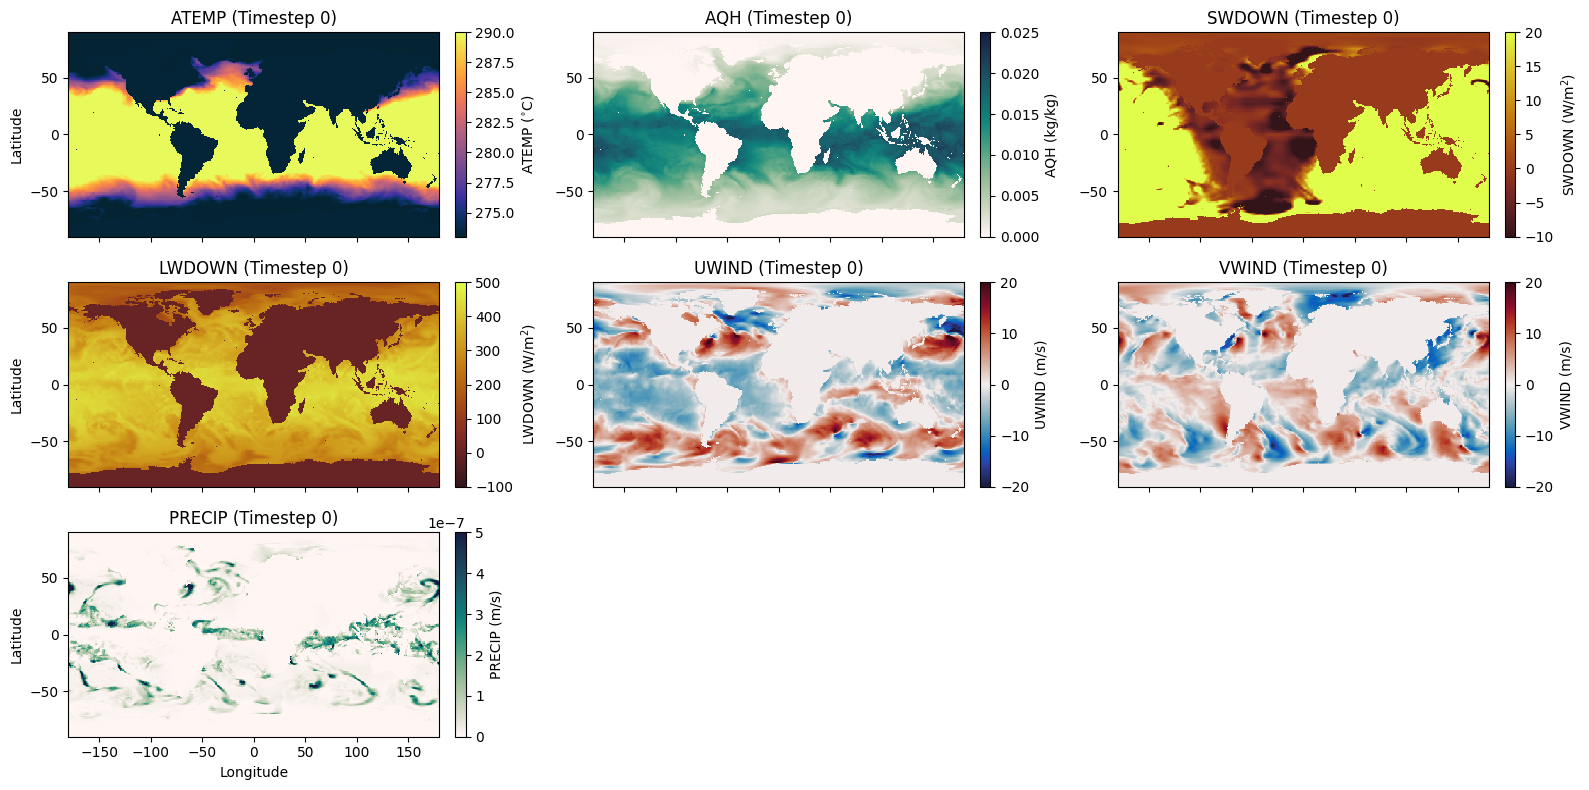

Step 4 (Plotting) completed in 3.84s


In [19]:
print("--- Step Four: Plotting EXF Fields ---")
start_step4_time = time.time()
meta_dict_ecf = {
    "ATEMP": [273, 290, cm.thermal, "$^{\\circ}$C"],
    "AQH": [0, 0.025, cm.tempo, "kg/kg"],
    "PRECIP": [0, 5e-7, cm.tempo, "m/s"],
    "SWDOWN": [-10, 20, cm.solar, "W/m$^2$"],
    "LWDOWN": [-100, 500, cm.solar, "W/m$^2$"],
    "UWIND": [-20, 20, cm.balance, "m/s"],
    "VWIND": [-20, 20, cm.balance, "m/s"],
    "RUNOFF": [0, 2e-8, cm.tempo, "m/s"],
}
fig = plt.figure(figsize=(16, 8))

plot_cols = 3
plot_rows = (len(variable_names_exf) + plot_cols - 1) // plot_cols
plots_made = 0

for i, variable_name in tqdm(enumerate(variable_names_exf)):
    filepath = os.path.join(input_dir_model, f"{variable_name}_{YEAR_EXF}")
    if not os.path.exists(filepath):
        print(f"Plotting skipped for {variable_name}: File not found ({filepath})")
        continue
    try:
        file_data = np.fromfile(filepath, dtype=">f4")
        elements_in_file = file_data.size

        elements_per_slice = N_ROWS_MODEL * N_COLS_MODEL

        if elements_in_file == 0:
            print(f"Warning: File for {variable_name} is empty. Skipping plot.")
            continue
        if elements_per_slice == 0:
            print("Warning: elements_per_slice is zero. Skipping plot.")
            continue

        n_timesteps_plot = 0
        if elements_in_file % elements_per_slice != 0:
            print(
                f"CRITICAL WARNING: File size for {variable_name} ({elements_in_file} elements) is not a multiple of grid slice size ({elements_per_slice} elements = {N_ROWS_MODEL}x{N_COLS_MODEL})."
            )
            if elements_in_file < elements_per_slice:
                print(
                    f"File for {variable_name} is smaller than one slice. Skipping plot."
                )
                continue
            n_timesteps_plot = elements_in_file // elements_per_slice
        else:
            n_timesteps_plot = elements_in_file // elements_per_slice

        if n_timesteps_plot == 0:
            print(f"Calculated 0 timesteps for {variable_name}. Skipping plot.")
            continue


        print(
            f"DEBUG: Plotting {variable_name}: Calculated n_timesteps_plot={n_timesteps_plot}. Reshaping with N_ROWS_MODEL={N_ROWS_MODEL}, N_COLS_MODEL={N_COLS_MODEL}"
        )

        global_exf_grid_np = file_data.reshape(
            (n_timesteps_plot, N_ROWS_MODEL, N_COLS_MODEL)
        )
        plot_data = global_exf_grid_np[0, :, :]  # Plot first timestep

        ax = fig.add_subplot(plot_rows, plot_cols, i + 1)
        meta = meta_dict_ecf.get(
            variable_name,
            [
                np.nanmin(plot_data) if plot_data.size > 0 else 0,
                np.nanmax(plot_data) if plot_data.size > 0 else 1,
                "viridis",
                "N/A",
            ],
        )
        C = ax.pcolormesh(
            XC_model_np,
            YC_model_np,
            plot_data,
            vmin=meta[0],
            vmax=meta[1],
            cmap=meta[2],
            shading="auto",
        )
        plt.colorbar(
            C, ax=ax, label=f"{variable_name} ({meta[3]})", fraction=0.046, pad=0.04
        )
        ax.set_title(f"{variable_name} (Timestep 0)")
        if i % plot_cols == 0:
            ax.set_ylabel("Latitude")
        if (i // plot_cols == plot_rows - 1) or (
            i
            >= len(variable_names_exf)
            - (
                len(variable_names_exf) % plot_cols
                if len(variable_names_exf) % plot_cols != 0
                else plot_cols
            )
        ):
            ax.set_xlabel("Longitude")
        else:
            ax.set_xticklabels([])
        plots_made += 1
    except FileNotFoundError:
        print(
            f"ERROR plotting {variable_name}: File not found at {filepath} (should have been caught)."
        )
    except ValueError as ve:
        print(
            f"ERROR plotting {variable_name} (ValueError): {ve}. Filepath: {filepath}"
        )
        print(
            f"  Attempted reshape with n_timesteps_plot={n_timesteps_plot if 'n_timesteps_plot' in locals() else 'unknown'}, N_ROWS_MODEL={N_ROWS_MODEL}, N_COLS_MODEL={N_COLS_MODEL}"
        )
        print(
            f"  Actual elements in file: {elements_in_file if 'elements_in_file' in locals() else 'unknown'}"
        )
    except Exception as e:
        print(f"ERROR plotting {variable_name} (General Error): {e}")

for j in trange(plots_made, plot_rows * plot_cols):
    fig.add_subplot(plot_rows, plot_cols, j + 1).axis("off")
plt.tight_layout()
plt.show()
step4_time = time.time() - start_step4_time
print(f"Step 4 (Plotting) completed in {step4_time:.2f}s")

## Step Five: Define the Nordic Seas Region (NumPy)

This is a critical step.

Assumed conventions:

- Latitude: Index 0 is South Pole (~-90 deg), index NY-1 (179) is North Pole ( +90 deg).
- Longitude: Index 0 is Prime Meridian (0 deg East), index NX-1 (359) is just west of 360 deg East.

Nordic Seas approximately 65N-80N, 20W-30E.

**Precipitation Modification**: 100% Increase (A 100% increase means multiplying the baseline precipitation by 2.0.)

In [21]:
# If 1-degree resolution grid where lat_index = geographic_lat + 90:
lat_idx_start = 65 + 90  # Index for 65N
lat_idx_end = 80 + 90  # Index for 80N (slice will go up to lat_idx_end - 1)

# If 1-degree resolution grid where lon_index = geographic_lon (for 0-359 range):
# 20W corresponds to 340E. 30E is 30.
# This region wraps around the 0/360 longitude. We define two slices:
lon_western_part_start_idx = 360 - 20  # Index for 20W (which is 340E)
lon_western_part_end_idx = N_COLS_MODEL  # Up to the edge of the grid (359)
lon_eastern_part_start_idx = 0  # From 0E
lon_eastern_part_end_idx = 30  # Index for 30E

# Factor for 100% increase (baseline * 2.0)
precip_increase_factor = 2.0

print(
    f"INFO: Applying a 100% increase (multiplying by {precip_increase_factor}) to precipitation in the specified region.\n"
)

print("--- Creating Increase Precipitation File ---\n")
baseline_precip_filename = os.path.join(input_dir_model, f"PRECIP_{YEAR_EXF}")
modified_precip_filename = os.path.join(
    input_dir_model, f"PRECIP_increase_{YEAR_EXF}"
)

# Ensure the input directory exists
if not os.path.isdir(input_dir_model):
    print(
        f"ERROR: Input directory '{input_dir_model}' not found. Please create it or set the correct path."
    )
    exit()

try:
    # 1. Load the baseline precipitation file
    precip_baseline_flat_np = np.fromfile(baseline_precip_filename, dtype=">f4")
    print(f"Successfully loaded baseline file: {baseline_precip_filename}")
    print(f"  Total elements in baseline file: {precip_baseline_flat_np.size}")

    if precip_baseline_flat_np.size == 0:
        raise ValueError("Baseline precipitation file is empty.")
    if precip_baseline_flat_np.size % (N_ROWS_MODEL * N_COLS_MODEL) != 0:
        raise ValueError(
            f"Total elements {precip_baseline_flat_np.size} is not an integer multiple of grid size {N_ROWS_MODEL * N_COLS_MODEL}."
            " This suggests the file may contain multiple time records, or NY/NX are incorrect."
        )

    # Determine number of time records (e.g., daily data for a year would have ~365 records)
    num_time_records = precip_baseline_flat_np.size // (N_ROWS_MODEL * N_COLS_MODEL)
    print(
        f"  Detected {num_time_records} time record(s) for a {N_ROWS_MODEL}x{N_COLS_MODEL} grid.\n"
    )

    # Reshape to (num_time_records, NY, NX)
    precip_baseline_3d_np = precip_baseline_flat_np.reshape(
        num_time_records, N_ROWS_MODEL, N_COLS_MODEL
    )

    # 2. Create a copy of the baseline data to modify
    precip_modified_3d_np = precip_baseline_3d_np.copy()

    # 3. Apply the increase to the Nordic Seas region for each time record
    print(
        f"Applying precipitation modification to Nordic Seas region (Lat Indices: {lat_idx_start}-{lat_idx_end - 1}, Lon Indices for wrapped region: {lon_western_part_start_idx}-{lon_western_part_end_idx - 1} AND {lon_eastern_part_start_idx}-{lon_eastern_part_end_idx - 1}).\n"
    )

    for t in trange(num_time_records):
        # Western part of the wrapped longitude (e.g., 20W to 0/360)
        precip_modified_3d_np[
            t,
            lat_idx_start:lat_idx_end,
            lon_western_part_start_idx:lon_western_part_end_idx,
        ] *= precip_increase_factor

        # Eastern part of the wrapped longitude (e.g., 0E to 30E)
        precip_modified_3d_np[
            t,
            lat_idx_start:lat_idx_end,
            lon_eastern_part_start_idx:lon_eastern_part_end_idx,
        ] *= precip_increase_factor

    # Ensure precipitation is not negative.
    precip_modified_3d_np[precip_modified_3d_np < 0] = 0.0

    # 4. Save the modified grid
    precip_modified_3d_np.ravel("C").astype(">f4").tofile(modified_precip_filename)
    print(f"Modified precipitation file created: {modified_precip_filename}\n")

except FileNotFoundError:
    print(
        f"ERROR: Baseline precipitation file not found at {baseline_precip_filename}. Please check 'input_dir_model' and filename."
    )
except ValueError as ve:
    print(f"ERROR processing precipitation file: {ve}")
except Exception as e:
    print(
        f"An unexpected ERROR occurred while creating increase precipitation files: {e}"
    )

print("--- External Forcing Conditions Generation Complete ---")

INFO: Applying a 100% increase (multiplying by 2.0) to precipitation in the specified region.

--- Creating Increase Precipitation File ---

Successfully loaded baseline file: /content/drive/MyDrive/cs185c/input/PRECIP_2009
  Total elements in baseline file: 94608000
  Detected 1460 time record(s) for a 180x360 grid.

Applying precipitation modification to Nordic Seas region (Lat Indices: 155-169, Lon Indices for wrapped region: 340-359 AND 0-29).



  0%|          | 0/1460 [00:00<?, ?it/s]

Modified precipitation file created: /content/drive/MyDrive/cs185c/input/PRECIP_increase_2009

--- External Forcing Conditions Generation Complete ---


DEBUG: Plotting PRECIP_increase: Calculated n_timesteps_plot=1460. Reshaping with N_ROWS_MODEL=180, N_COLS_MODEL=360
  Displaying first time step. Data range: min=0.00e+00 m/s, max=2.53e-06 m/s


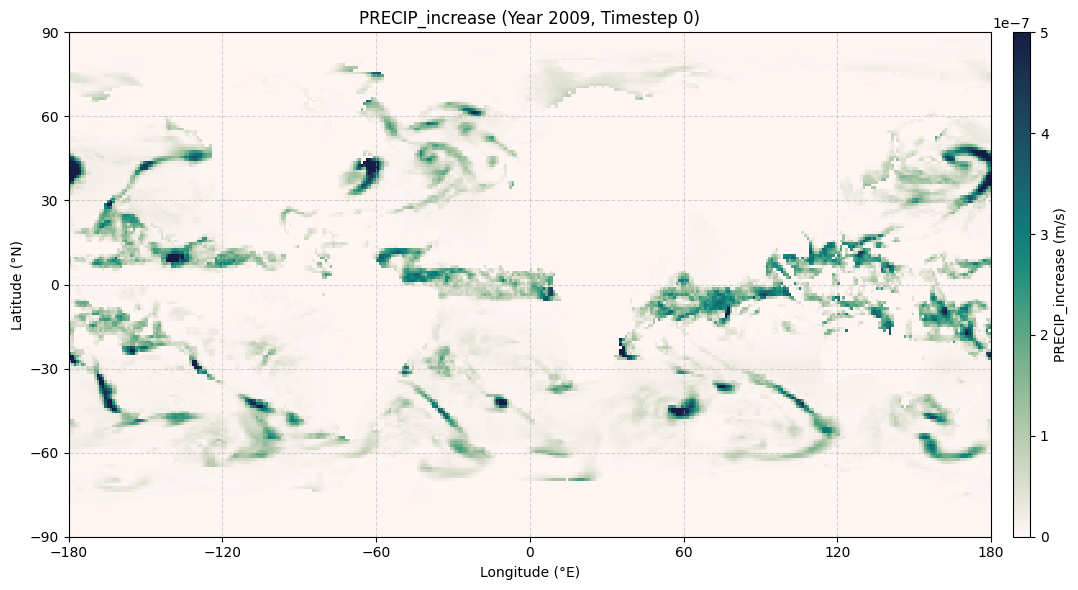

In [22]:
target_file_basename = f"PRECIP_increase_{YEAR_EXF}"

meta_dict_plot = {
    "PRECIP_increase": [0, 5.0e-7, cm.tempo, "m/s"],
}
plot_variable_name = "PRECIP_increase"
lon_centers = np.linspace(
    XG_ORIGIN_MODEL + DEL_X_MODEL / 2.0,
    XG_ORIGIN_MODEL + (N_COLS_MODEL - 0.5) * DEL_X_MODEL,
    N_COLS_MODEL,
)
lat_centers = np.linspace(
    YG_ORIGIN_MODEL + DEL_Y_MODEL / 2.0,
    YG_ORIGIN_MODEL + (N_ROWS_MODEL - 0.5) * DEL_Y_MODEL,
    N_ROWS_MODEL,
)
XC_model_np, YC_model_np = np.meshgrid(lon_centers, lat_centers, indexing="xy")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

filepath = os.path.join(input_dir_model, target_file_basename)

if not os.path.exists(filepath):
    print(f"ERROR: Plotting skipped. File not found: {filepath}")
else:
    try:
        file_data = np.fromfile(filepath, dtype=">f4")
        elements_in_file = file_data.size

        elements_per_slice = N_ROWS_MODEL * N_COLS_MODEL

        if elements_in_file == 0:
            print(f"Warning: File {target_file_basename} is empty. Skipping plot.")
        elif elements_per_slice == 0:
            print(
                "Warning: N_ROWS_MODEL or N_COLS_MODEL is zero, elements_per_slice is zero. Skipping plot."
            )
        else:
            n_timesteps_plot = 0
            if elements_in_file % elements_per_slice != 0:
                print(
                    f"CRITICAL WARNING: File size for {target_file_basename} ({elements_in_file} elements) "
                    f"is not a multiple of grid slice size ({elements_per_slice} elements = {N_ROWS_MODEL}x{N_COLS_MODEL})."
                )
                if elements_in_file < elements_per_slice:
                    print(
                        f"File for {target_file_basename} is smaller than one slice. Skipping plot."
                    )
                    n_timesteps_plot = -1
                else:
                    n_timesteps_plot = elements_in_file // elements_per_slice
                    print(
                        f"  File will be reshaped using the first {n_timesteps_plot} complete time slice(s)."
                    )
            else:
                n_timesteps_plot = elements_in_file // elements_per_slice

            if n_timesteps_plot > 0:
                print(
                    f"DEBUG: Plotting {plot_variable_name}: Calculated n_timesteps_plot={n_timesteps_plot}. "
                    f"Reshaping with N_ROWS_MODEL={N_ROWS_MODEL}, N_COLS_MODEL={N_COLS_MODEL}"
                )

                global_exf_grid_np = file_data[
                    : n_timesteps_plot * elements_per_slice
                ].reshape((n_timesteps_plot, N_ROWS_MODEL, N_COLS_MODEL))
                plot_data = global_exf_grid_np[0, :, :]  # Plot first timestep
                print(
                    f"  Displaying first time step. Data range: min={plot_data.min():.2e} m/s, max={plot_data.max():.2e} m/s"
                )

                meta = meta_dict_plot.get(
                    plot_variable_name,
                    [
                        np.nanmin(plot_data) if plot_data.size > 0 else 0,
                        np.nanmax(plot_data) if plot_data.size > 0 else 1,
                        "viridis",
                        "N/A",
                    ],
                )

                C = ax.pcolormesh(
                    XC_model_np,
                    YC_model_np,
                    plot_data,
                    vmin=meta[0],
                    vmax=meta[1],
                    cmap=meta[2],
                    shading="auto",
                )

                plt.colorbar(
                    C,
                    ax=ax,
                    label=f"{plot_variable_name} ({meta[3]})",
                    orientation="vertical",
                    pad=0.02,
                    aspect=30,
                )
                ax.set_title(f"{plot_variable_name} (Year {YEAR_EXF}, Timestep 0)")
                ax.set_ylabel("Latitude (°N)")
                ax.set_xlabel("Longitude (°E)")
                ax.set_xticks(np.arange(-180, 181, 60))
                ax.set_yticks(np.arange(-90, 91, 30))
                ax.grid(True, linestyle="--", alpha=0.5)

            elif (
                n_timesteps_plot == 0
            ):
                print(
                    f"Calculated 0 timesteps for {plot_variable_name}, although file seemed valid. Skipping plot."
                )

    except ValueError as ve:
        print(
            f"ERROR plotting {plot_variable_name} (ValueError): {ve}. Filepath: {filepath}"
        )
        if (
            "n_timesteps_plot" in locals()
            and "elements_in_file" in locals()
            and "elements_per_slice" in locals()
        ):
            print(
                f"  Attempted reshape with n_timesteps_plot={n_timesteps_plot}, N_ROWS_MODEL={N_ROWS_MODEL}, N_COLS_MODEL={N_COLS_MODEL}"
            )
            print(
                f"  Actual elements in file: {elements_in_file}, elements_per_slice: {elements_per_slice}"
            )
    except Exception as e:
        print(f"ERROR plotting {plot_variable_name} (General Error): {e}")

    plt.tight_layout()
    plt.show()